<a href="https://colab.research.google.com/github/Nico314159/Shape_Recognition_Learning/blob/main/ShapesProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from os import symlink
import sys
import pathlib
from pathlib import Path

# Dataset comes from: https://www.kaggle.com/datasets/reevald/geometric-shapes-mathematics
original_path = Path("/content/drive/MyDrive/Machine_Learning_AE_2024/dataset")
new_path = Path("/content/project")

try:
 new_path.symlink_to(original_path)
 sys.path.insert(0, str(new_path))
except FileExistsError: pass

In [3]:
import pandas as pd
import seaborn as sls
import numpy as np
#import Tensorflow as tf


In [235]:
import cv2
from PIL import Image
from PIL import ImageMath
from IPython.display import display
from os import listdir
from typing import Final
import matplotlib.pyplot as plt

import glob
import random
import base64

from io import BytesIO
from IPython.display import HTML

!pip install natsort[fast]
from natsort import os_sorted

def absolute_listdir(dataset: str, kind: str):
  if dataset not in {'test', 'train', 'val'}:
    raise ValueError("Invalid dataset")

  kinds = listdir(Path(original_path, dataset))
  if kind not in kinds:
    raise ValueError("Invalid dataset")

  dir = listdir(Path(original_path, dataset, kind))
  return [Path(original_path, dataset, kind, f) for f in dir]

# paths:dict[str, str] = {}
# dirs:dict[str, list] = {}

# SHAPES:Final[list[str]] = ["circle", "square", 'kite']

# for s in SHAPES:
#  paths[s] = f"{original_path}/train/{s}"
#  dirs[s] = [path.join(paths[s], f) for f in listdir(paths[s])]

# print(dirs["circle"])
# # print(len(dirs['circle']))

In [236]:
pd.set_option('display.max_colwidth', None)

def get_thumbnail(path: Path):
    i = Image.open(str(path))
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [237]:
global EXCLUDE_SHAPES
EXCLUDE_SHAPES = "rhombus", "parallelogram", "trapezoid", "rectangle"

def create_df(dataset):
    if dataset not in {"test", "train", "val"}: raise ValueError()
    df = []
    data_path = original_path / dataset

    global SHAPES
    SHAPES = [p.stem for p in data_path.iterdir()
                      if p.stem != '.ipynb_checkpoints'
                     and p.stem not in set(EXCLUDE_SHAPES)]
    print(SHAPES)

    for kind_num, kind in enumerate(SHAPES):
        for img_path in os_sorted((data_path / kind).iterdir()):
            img_path = data_path / kind / img_path
            if img_path.suffix == '.jpg':
                thumbnail = get_thumbnail(img_path)
                df.append([img_path, thumbnail, kind, kind_num])
    df = pd.DataFrame(df, columns=['path', 'image', 'kind', 'kind_num'])
    return df

df_train = create_df('train')
# df_train = pd.DataFrame({"image": image_list, 'kind': shape_list, 'path': full_path_list})


['circle', 'kite', 'triangle', 'square']


In [238]:
def pretty_print(df):
  return HTML(df.to_html(formatters={'image': image_formatter}, escape=False))

# df_train = df_train.sample(frac=1.0)
# pretty_print(df_train['path'])

In [239]:
from random import randint, choice

img = df_train.iloc[5, 0]

# Function to read and convert an image from BGR to RGB
def imread(img_path: Path):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Function to display an image
def imshow(img, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()

# Function to convert an RGB image to binary
def rgb2bin(img_rgb):
      img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
      _, img_bin = cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
      return img_bin

# Function to find the largest contour in an image
def find_best_contour(img_rgb):
    img_bin = rgb2bin(img_rgb)
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    best_contour = max(contours, key=cv2.contourArea)
    return best_contour

# # Function to draw contours on an image
# def draw_contours(img, contours, index=-1, color=(255, 0, 0), thickness=2):
#     img_copy = img.copy()
#     cv2.drawContours(img_copy, contours, index, color, thickness)
#     imshow(img_copy)

# Function to create a histogram of chain code directions
def chain_hist(img_rgb):
    best_contour = find_best_contour(img_rgb)
    lookup_table = {(1, 0): 0, (1, -1): 1, (0, -1): 2, (-1, -1): 3,
                    (-1, 0): 4, (-1, 1): 5, (0, 1): 6, (1, 1): 7}
    hist = np.zeros((8,))
    for i in range(len(best_contour)-1):
        pt1 = best_contour[i][0]
        pt2 = best_contour[i+1][0]
        dx = pt2[0] - pt1[0]
        dy = pt2[1] - pt1[1]
        code = lookup_table[(dx, dy)]
        hist[code] += 1
    return hist/hist.sum()

# Function to extract features from the image paths
def extract_features(my_listdir: list[Path]):
    # my_listdir = dirs[kind]
    if not isinstance(my_listdir, list):
      try:my_listdir \
        = my_listdir.tolist();
      except: raise TypeError("You need to input a list")
    n = len(my_listdir)
    X = np.zeros((n, 8))
    for i in range(n):
        f_path = my_listdir[i]
        img = imread(f_path)
        features = chain_hist(img)
        X[i] = features
    return X

# Function to predict the class of a given image
def predict(model, img):
    features = chain_hist(img)
    prediction = model.predict([features])[0]
    return SHAPES[prediction]

# Detect connected components and predict labels
def detect_connected_components(img, width_range, height_range):
    # for erode_size in range(0, 5):
    #   iters = 4
    #   kernerl_8_way = np.ones(shape=(erode_size,erode_size))
    #   erode   = cv2.erode( img_threshold  , kernel = kernerl_8_way, iterations=iters)
    #   dilate  = cv2.dilate(erode          , kernel = kernerl_8_way, iterations=iters)
    #   # concat  = np.hstack((concat,img_threshold, erode,dilate))
    #   # print(concat.all(0))

    nLabels = None
    for i in range(10):
      binary_img = rgb2bin(img)

      img_gray = binary_img
      concat = img_gray
      img_threshold = np.uint8((img_gray > 128)*255)

      nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(concat, connectivity=8)
      # print((nLabels, labels, stats, centroids))
      if True:
        break
      # else:
      #   shape = choice(SHAPES)
      #   img = imread(original_path / 'test' / f'{shape}' / f'{shape}-{randint(2000, 2499)}.jpg')


    centroids = centroids.astype(int)
    img_copy = img.copy()
    for i in range(1, nLabels):
        x, y, w, h, _ = stats[i]
        (cx, cy) = centroids[i]
        acceptWidth = width_range[0] < w < width_range[1]
        acceptHeight = height_range[0] < h < height_range[1]
        if acceptWidth and acceptHeight:
            shape = img[y:y+h, x:x+w]
            # print(img, shape)
            label = predict(stacked_model, shape)
            cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)
            cv2.putText(img_copy, label, (x, y-4), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0))
    imshow(img_copy, figsize=(10, 10))


In [240]:
# Extract features from the images
x_train = extract_features(df_train['path'].tolist())
# x_train = [l.tolist() for l in x_train]
y_train = df_train['kind_num']

df_test = create_df('test')
x_test = extract_features(df_test['path'].tolist())
# x_test = [l.tolist() for l in x_test]
y_test = df_test['kind_num']

# merged_df = pd.concat([df_train, df_test])
# X = extract_features(merged_df['path'].tolist())
# X = np.asarray(l[0:2] for l in X)
# Y = merged_df['kind_num']
# # print(x_train)

['triangle', 'circle', 'kite', 'square']


In [199]:
print(x_test)

[[0.06756757 0.18581081 0.10135135 ... 0.02027027 0.29222973 0.05067568]
 [0.27586207 0.13793103 0.02586207 ... 0.12931034 0.01724138 0.06896552]
 [0.01724138 0.01149425 0.25862069 ... 0.01149425 0.27586207 0.20689655]
 ...
 [0.21621622 0.04633205 0.2046332  ... 0.05019305 0.1969112  0.03861004]
 [0.03571429 0.04761905 0.32142857 ... 0.04761905 0.30952381 0.10714286]
 [0.21449275 0.03478261 0.22028986 ... 0.03768116 0.20869565 0.03768116]]


In [189]:
# from sklearn import neighbors

# model2 = neighbors.NearestNeighbors(metric="euclidean").fit(x_train, y_train)

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

# clf = Pipeline(
#     steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
# )

In [241]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

# Extract features from the images
x = extract_features(df_test['path'])

# Labels
y = df_test['kind_num']

# Splitting the dataset into training and testing sets
# x_train = x_train.to_list()
# print(len(x_train))
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=22)
print(type(x_train))

base_models = [
    ('rf', RandomForestClassifier(n_estimators=200)),  # Random Forest
    ('xgb', XGBClassifier(n_estimators=200)),          # XGBoost
    ('et', ExtraTreesClassifier(n_estimators=200))     # Extra Trees
]

# Define the meta-learner
meta_learner = GradientBoostingClassifier(n_estimators=50)  # Gradient Boosting

# Initialize the Stacking model
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_learner, n_jobs=-1, cv=5)

# Train the Stacking model
stacked_model.fit(x_train, y_train)

# Evaluate the model
y_pred_train = stacked_model.predict(x_train)
y_pred_test = stacked_model.predict(x_test)

print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))

<class 'numpy.ndarray'>
Training Accuracy: 0.9921465968586387
Testing Accuracy: 0.2885


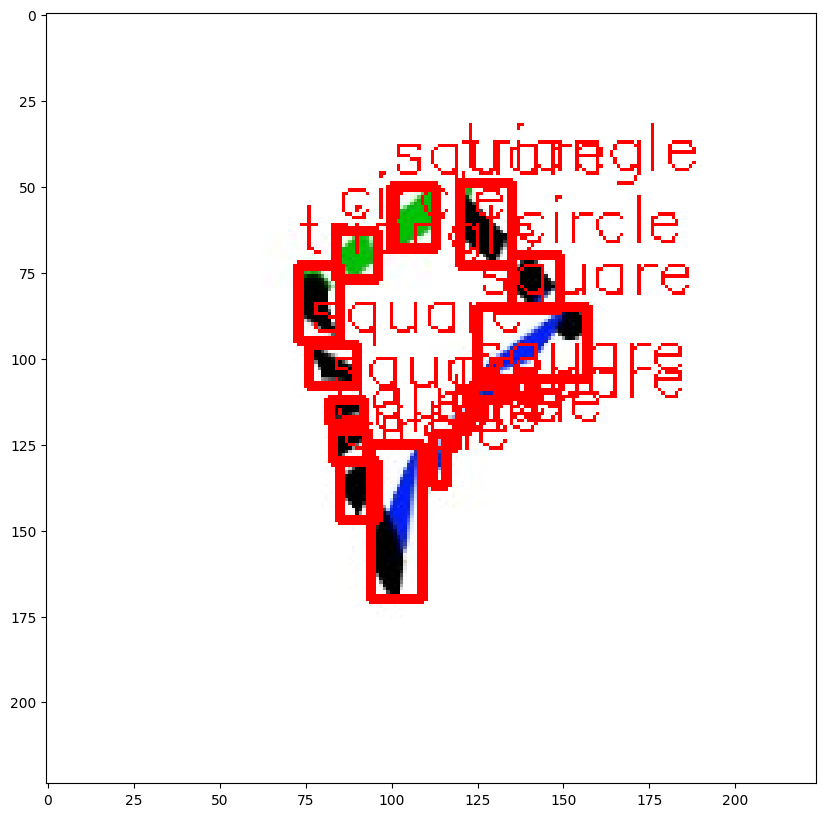

In [247]:
# Example usage
from random import randint, choice
shape = choice(SHAPES)

my_img = imread(original_path / 'test' / f'{shape}' / f'{shape}-{randint(2000, 2499)}.jpg')
# imshow(test_img)
detect_connected_components(my_img, width_range=(1, 600), height_range=(1, 600))